In [1]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import glob
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F

/home/ubuntu/DuyPham/.venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Define Dataset Class and DataLoader

In [2]:
def apply_gamma_correction(image, gamma=1.0):
    image_normalized = image / 255.0
    gamma_corrected = np.power(image_normalized, gamma)
    gamma_corrected = np.uint8(gamma_corrected * 255)

    return gamma_corrected

In [3]:
def preprocessing_img(path):
    img=cv2.imread(path,0)
    clahe = cv2.createCLAHE(clipLimit=11, tileGridSize=(12, 12))
    clahe_img = clahe.apply(img)
    out = apply_gamma_correction(clahe_img,2)

    return out

In [4]:
def sobel_transforms(image):
    blur_img=cv2.GaussianBlur(image,(3,3),1)
    sb_x =cv2.Sobel(blur_img,-1,1,0)
    sb_y =cv2.Sobel(blur_img,-1,0,1)
    sb = (sb_x+sb_y)/2
    return sb

In [5]:
class CustomDataset(Dataset):
    def __init__(self,img_paths,mask_paths,img_transforms=None):
        super().__init__()
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.img_transforms = img_transforms
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        mask_path = self.mask_paths[index]
        img  = np.array(Image.open(img_path).convert('L').convert('RGB'),dtype=np.uint8)
        mask = (np.array(Image.open(mask_path),dtype=np.uint8)[:,:,0]/255).astype(np.uint8)
        if self.img_transforms is not None:
            transform =  self.img_transforms(image = img,mask=mask)
            t_image  = transform['image']
            t_mask =  transform['mask']
        else:
            raise Exception('Transforms is compulsory')
        
        return {
            'image':t_image,
            'mask':t_mask,
        }

**Split to train test**

In [6]:
train_image_paths =  sorted(glob.glob('/home/ubuntu/DuyPham/five/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Original/*png'))
test_image_paths =   sorted(glob.glob('/home/ubuntu/DuyPham/five/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/*png'))

train_mask_paths = sorted(glob.glob('/home/ubuntu/DuyPham/five/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train/Ground truth/*png'))
test_mask_paths =  sorted(glob.glob('/home/ubuntu/DuyPham/five/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/*png'))

**Define train_set and train_image_transforms**

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_image_transforms = A.Compose(
    [
        A.Resize(256, 256, interpolation=cv2.INTER_AREA),  
        A.Normalize(mean=(0.5,0.5,0.5,), std=(0.5,0.5,0.5,)),
        ToTensorV2(),  
    ],
    # additional_targets={'sobel': 'image', 'image': 'image', 'mask': 'mask'}
)

In [8]:
def decode(img):
    clone_img = img.clone().squeeze().detach().cpu()
    if len(clone_img.shape) > 2:
        clone_img=clone_img.permute(1,2,0).numpy()
    else:
        clone_img=clone_img.numpy()
    clone_img=clone_img*0.5+0.5
    return (clone_img*255).astype(np.uint8)


In [9]:

all_train_set=CustomDataset(train_image_paths,train_mask_paths,train_image_transforms)
train_set,val_set=random_split(all_train_set,[0.75,0.25],generator=torch.Generator().manual_seed(42))

In [10]:
test_set = CustomDataset(test_image_paths,test_mask_paths,train_image_transforms)

In [11]:
batch_size = 64
train_loader = DataLoader(train_set,batch_size,shuffle=True,num_workers=4,generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_set,batch_size,shuffle=True,num_workers=4,generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_set,batch_size,shuffle=False)

# Define Model

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channel, out_channel, mid_channel=None):
        super().__init__()
        if not mid_channel:
            mid_channel = out_channel

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channel, mid_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channel),
            nn.ReLU(),
            nn.Conv2d(mid_channel, out_channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

class DownScaling(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.downscaling = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channel, out_channel)
        )

    def forward(self, x):
        return self.downscaling(x)

class UpScaling(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.upscaling = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channel, out_channel)

    def forward(self, x1, x2): # x1 from ConvTransposed, x2 from Encoder
        x1 = self.upscaling(x1)

        delta_height = x2.size()[2] - x1.size()[2]
        delta_width = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [delta_width // 2, delta_width - delta_width // 2,
                        delta_height // 2, delta_height - delta_height // 2])

        x = torch.cat([x2, x1], dim=1)

        return self.double_conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNETModel(nn.Module):
    def __init__(self, n_channel, n_class):
        super().__init__()
        self.n_channel = n_channel
        self.n_class = n_class

        self.first_conv = DoubleConv(n_channel, 64)
        
        self.down1 = DownScaling(64, 128)
        self.down2 = DownScaling(128, 256)
        self.down3 = DownScaling(256, 512)
        self.up2 = UpScaling(512, 256)
        self.up3 = UpScaling(256, 128)
        self.up4 = UpScaling(128, 64)

        self.final_conv = OutConv(64, n_class)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.final_conv(x)

In [14]:
from torchinfo import summary

In [15]:
summary(UNETModel(3,1),input_data=(torch.rand(1,3,512,512)))

Layer (type:depth-idx)                        Output Shape              Param #
UNETModel                                     [1, 1, 512, 512]          --
├─DoubleConv: 1-1                             [1, 64, 512, 512]         --
│    └─Sequential: 2-1                        [1, 64, 512, 512]         --
│    │    └─Conv2d: 3-1                       [1, 64, 512, 512]         1,792
│    │    └─BatchNorm2d: 3-2                  [1, 64, 512, 512]         128
│    │    └─ReLU: 3-3                         [1, 64, 512, 512]         --
│    │    └─Conv2d: 3-4                       [1, 64, 512, 512]         36,928
│    │    └─BatchNorm2d: 3-5                  [1, 64, 512, 512]         128
│    │    └─ReLU: 3-6                         [1, 64, 512, 512]         --
├─DownScaling: 1-2                            [1, 128, 256, 256]        --
│    └─Sequential: 2-2                        [1, 128, 256, 256]        --
│    │    └─MaxPool2d: 3-7                    [1, 64, 256, 256]         --
│    │    └

In [16]:
# from torchinfo import summary
# from thop import profile
# # from CustomNET import CustomNET
# flops, params = profile(CustomNET(3,1), inputs=(torch.rand(1,3,960,960),torch.rand(1,3,960,960)),verbose=False)
# print(summary(CustomNET(3,1),input_data=(torch.rand(1,3,960,960),torch.rand(1,3,960,960))))

# print(flops,params)

In [17]:
import math
def plot(segmodel,sample,device):
    model = segmodel
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        image,mask=sample.values()
        fig,ax = plt.subplots(1,3,figsize=(12,8))
        pred_mask = model(image.unsqueeze(0).to(device))
        ax[0].imshow(decode(image),cmap='gray')
        ax[0].axis(False)
        ax[0].set_title('Image',c='black')

        ax[1].imshow(mask.cpu())
        ax[1].axis(False)
        ax[1].set_title('True mask',c='black')


        ax[2].imshow(torch.where(pred_mask>0.5,1,0).squeeze().detach().cpu())
        ax[2].axis(False)
        ax[2].set_title('Pred Mask',c='green')
        plt.show()

In [18]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

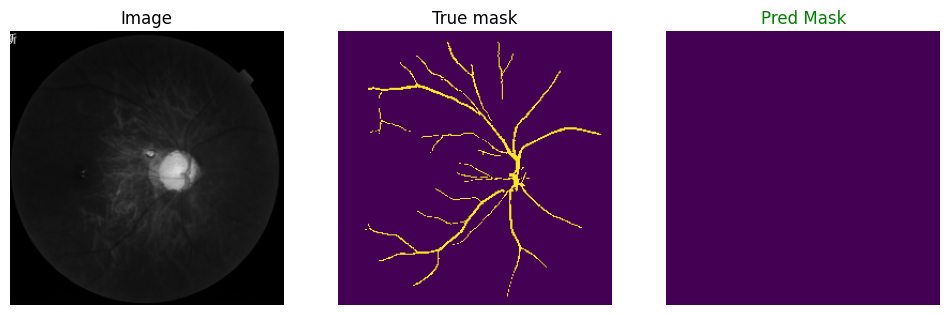

In [19]:
plot(nn.Sequential(UNETModel(3,1),nn.Sigmoid()),test_set[1],device)

# Train

**Define Loss**

In [20]:
class CustomSegLoss(nn.Module):
    def __init__(self,alpha=1):
        super().__init__()
        self.alpha=alpha
    def forward(self,pred,truth):
        
        pred=pred.squeeze()
        truth=truth.squeeze()
        # bce Loss
        # bce = nn.BCELoss()(pred,truth.type(torch.float32))

        # Abe Dice Loss

        erc = torch.pow(pred,2*(1-(pred**2)))
        abe_diceloss_all = 1-(torch.sum(2*erc*truth)/torch.sum(erc**2 +truth))
        return self.alpha*abe_diceloss_all

In [21]:
# unet_model =nn.Sequential(UNETModel(3,1),nn.Sigmoid()).to(device)

# unet_model = nn.DataParallel(unet_model,device_ids=[1,2,3,0]) 

In [22]:
model =nn.Sequential(UNETModel(3,1),nn.Sigmoid()).to(device)
model = nn.DataParallel(model,device_ids=[1,2,3,0]) 

In [23]:
from torch.optim import Adam
optimizer =Adam(model.parameters(),lr=3e-4,weight_decay=1e-5)
criterion =CustomSegLoss()

In [24]:
from torchmetrics.classification import BinaryF1Score,AUROC, Recall, Specificity
def eval_for_seg(model,val_loader,device):
    with torch.no_grad():
        model.eval()
        truth_label=[]
        pred_label=[]
        for sample in val_loader:
            image,mask=sample.values()
            
            image=image.to(device)
            mask=mask.to(device)
            pred_mask = torch.where(model(image)>0.5,1,0).cpu().flatten()
            truth_label.extend(mask.flatten().tolist())
            pred_label.extend(pred_mask.detach().numpy().tolist())
        truth_label=torch.tensor(truth_label)
        pred_label= torch.tensor(pred_label)
        return BinaryF1Score()(pred_label,truth_label),\
            Recall(task='binary')(pred_label,truth_label).item(),\
            Specificity(task='binary')(pred_label,truth_label).item(),\
            AUROC(task='binary')(pred_label,truth_label).item()

In [25]:
from tqdm import tqdm
def train_one_epoch_for_seg(model,train_loader,optimizer,criterion,device):
    model.train()
    training_loss = 0 
    for sample in tqdm(train_loader):
        image,mask=sample.values()
        image=image.to(device)
        mask=mask.to(device)

        pred_mask = model(image)

        loss = criterion(pred_mask,mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss+=loss.item()
    return training_loss/len(train_loader)


In [26]:
def train_seg(epochs,model,train_loader,val_loader,optimizer,criterion,device,save_dir='./best_seg_model.pth'):
    best_val_f1=0
    for e in tqdm(range(epochs)):
        training_loss=train_one_epoch_for_seg(model,train_loader,optimizer,criterion,device)
        val_f1, val_recall, val_specificity, val_auroc = eval_for_seg(model,val_loader,device)
        print(f'Epoch [{e}/{epochs}]: training loss {training_loss} val f1 {val_f1} val recall {val_recall} val specificity {val_specificity} val auroc {val_auroc}')
        if best_val_f1 < val_f1:
            best_val_f1=val_f1
            if isinstance(model,nn.DataParallel):
                torch.save(model.module.state_dict(), save_dir)
            else:
                torch.save(model.state_dict(), save_dir)
            print('===>Save model')
        if e%10==0:
            print(training_loss)
            plot(model,test_set[0],device)

100%|██████████| 8/8 [00:21<00:00,  2.66s/it]


Epoch [0/30]: training loss 0.6386413350701332 val f1 0.0 val recall 0.0 val specificity 1.0 val auroc 0.5
0.6386413350701332


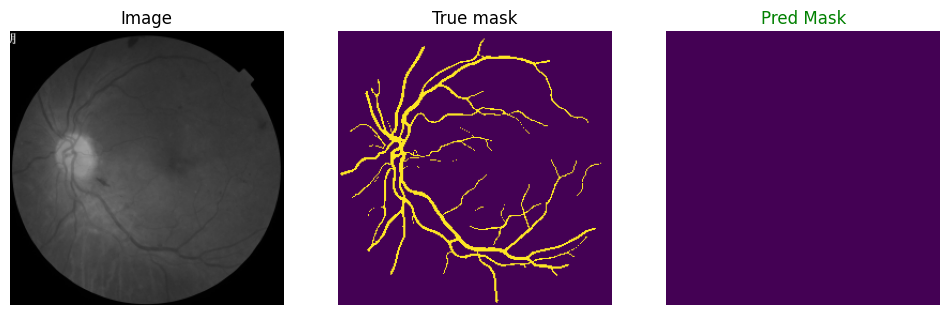

  7%|▋         | 2/30 [01:11<16:37, 35.61s/it]

Epoch [1/30]: training loss 0.4399598017334938 val f1 0.001829666318371892 val recall 0.0011298832250759006 val specificity 0.9806630611419678 val auroc 0.49089646339416504
===>Save model


 10%|█         | 3/30 [01:45<15:41, 34.86s/it]

Epoch [2/30]: training loss 0.36056775599718094 val f1 0.02041543647646904 val recall 0.0181647390127182 val specificity 0.9370691180229187 val auroc 0.47761693596839905
===>Save model


 13%|█▎        | 4/30 [02:19<14:57, 34.50s/it]

Epoch [3/30]: training loss 0.3349328115582466 val f1 0.15928325057029724 val recall 0.16983291506767273 val specificity 0.9204313158988953 val auroc 0.5451321005821228
===>Save model


 17%|█▋        | 5/30 [02:54<14:24, 34.59s/it]

Epoch [4/30]: training loss 0.3299461305141449 val f1 0.33782336115837097 val recall 0.3356153070926666 val specificity 0.9461641311645508 val auroc 0.6408896446228027
===>Save model


 20%|██        | 6/30 [03:28<13:51, 34.65s/it]

Epoch [5/30]: training loss 0.30023468285799026 val f1 0.5727846026420593 val recall 0.5832329392433167 val specificity 0.9625355005264282 val auroc 0.7728841304779053
===>Save model


 23%|██▎       | 7/30 [04:03<13:17, 34.67s/it]

Epoch [6/30]: training loss 0.2637416645884514 val f1 0.5989001393318176 val recall 0.7049325704574585 val specificity 0.9463422298431396 val auroc 0.8256374001502991
===>Save model


 27%|██▋       | 8/30 [04:38<12:43, 34.72s/it]

Epoch [7/30]: training loss 0.259981669485569 val f1 0.6972139477729797 val recall 0.71279376745224 val specificity 0.9725661277770996 val auroc 0.8426799178123474
===>Save model


 30%|███       | 9/30 [05:11<12:01, 34.35s/it]

Epoch [8/30]: training loss 0.22912544012069702 val f1 0.7113572955131531 val recall 0.7761658430099487 val specificity 0.9664373397827148 val auroc 0.8713015913963318
===>Save model


 33%|███▎      | 10/30 [05:45<11:21, 34.07s/it]

Epoch [9/30]: training loss 0.21247204393148422 val f1 0.6856677532196045 val recall 0.8124886751174927 val specificity 0.9539241790771484 val auroc 0.8832064270973206


100%|██████████| 8/8 [00:19<00:00,  2.40s/it]


Epoch [10/30]: training loss 0.20545078814029694 val f1 0.6807227730751038 val recall 0.839435338973999 val specificity 0.9481844305992126 val auroc 0.8938098549842834
0.20545078814029694


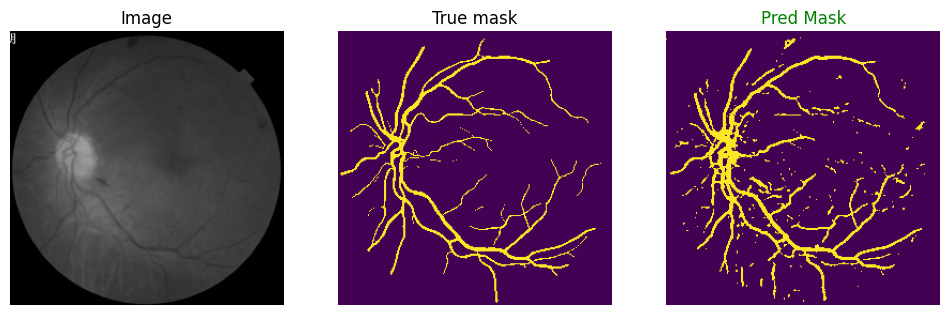

 40%|████      | 12/30 [06:51<10:03, 33.54s/it]

Epoch [11/30]: training loss 0.20511191338300705 val f1 0.7404360771179199 val recall 0.7057839632034302 val specificity 0.9834175109863281 val auroc 0.8446007370948792
===>Save model


 43%|████▎     | 13/30 [07:24<09:27, 33.40s/it]

Epoch [12/30]: training loss 0.19357164204120636 val f1 0.7253112196922302 val recall 0.8404253125190735 val specificity 0.9605728387832642 val auroc 0.9004991054534912


 47%|████▋     | 14/30 [07:57<08:50, 33.17s/it]

Epoch [13/30]: training loss 0.1898188441991806 val f1 0.777010977268219 val recall 0.7689268589019775 val specificity 0.9826200604438782 val auroc 0.8757734894752502
===>Save model


 50%|█████     | 15/30 [08:29<08:12, 32.84s/it]

Epoch [14/30]: training loss 0.1855584681034088 val f1 0.7696232795715332 val recall 0.7753637433052063 val specificity 0.9801990985870361 val auroc 0.8777814507484436


 53%|█████▎    | 16/30 [09:01<07:38, 32.76s/it]

Epoch [15/30]: training loss 0.17376037687063217 val f1 0.7908177971839905 val recall 0.8122515082359314 val specificity 0.9800006151199341 val auroc 0.8961260914802551
===>Save model


 57%|█████▋    | 17/30 [09:33<07:03, 32.61s/it]

Epoch [16/30]: training loss 0.16933532804250717 val f1 0.8027902245521545 val recall 0.8191520571708679 val specificity 0.9816822409629822 val auroc 0.900417149066925
===>Save model


 60%|██████    | 18/30 [10:06<06:32, 32.71s/it]

Epoch [17/30]: training loss 0.15640056133270264 val f1 0.8046726584434509 val recall 0.8327786326408386 val specificity 0.98040372133255 val auroc 0.9065912365913391
===>Save model


 63%|██████▎   | 19/30 [10:40<06:03, 33.01s/it]

Epoch [18/30]: training loss 0.15045230090618134 val f1 0.8129870295524597 val recall 0.8365413546562195 val specificity 0.9816992878913879 val auroc 0.9091204404830933
===>Save model


 67%|██████▋   | 20/30 [11:15<05:35, 33.51s/it]

Epoch [19/30]: training loss 0.15250545740127563 val f1 0.790151834487915 val recall 0.7654719352722168 val specificity 0.9857780337333679 val auroc 0.8756250143051147


100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


Epoch [20/30]: training loss 0.14773652702569962 val f1 0.8088318705558777 val recall 0.800251841545105 val specificity 0.9852429628372192 val auroc 0.8927474021911621
0.14773652702569962


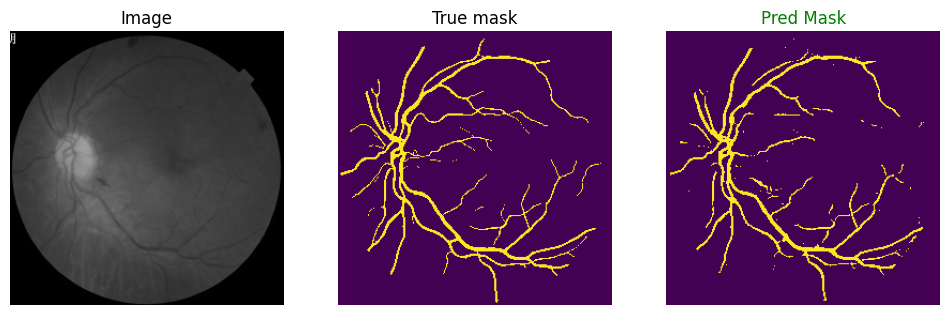

 73%|███████▎  | 22/30 [12:23<04:31, 33.93s/it]

Epoch [21/30]: training loss 0.16607217490673065 val f1 0.8024366497993469 val recall 0.7889410257339478 val specificity 0.9853346943855286 val auroc 0.8871378898620605


 77%|███████▋  | 23/30 [12:56<03:54, 33.46s/it]

Epoch [22/30]: training loss 0.17047493904829025 val f1 0.6780110001564026 val recall 0.6263697147369385 val specificity 0.9817079901695251 val auroc 0.8040388822555542


 80%|████████  | 24/30 [13:29<03:20, 33.40s/it]

Epoch [23/30]: training loss 0.16140331327915192 val f1 0.7790228128433228 val recall 0.8578758835792542 val specificity 0.9715191125869751 val auroc 0.9146974682807922


 83%|████████▎ | 25/30 [14:02<02:47, 33.44s/it]

Epoch [24/30]: training loss 0.14317745715379715 val f1 0.7889654040336609 val recall 0.8814048767089844 val specificity 0.9708280563354492 val auroc 0.9261165261268616


 87%|████████▋ | 26/30 [14:36<02:13, 33.41s/it]

Epoch [25/30]: training loss 0.14009571820497513 val f1 0.828162431716919 val recall 0.818443238735199 val specificity 0.9869331121444702 val auroc 0.902688205242157
===>Save model


 90%|█████████ | 27/30 [15:09<01:40, 33.36s/it]

Epoch [26/30]: training loss 0.15639036148786545 val f1 0.8277801275253296 val recall 0.8363494873046875 val specificity 0.9847617149353027 val auroc 0.9105556011199951


 93%|█████████▎| 28/30 [15:42<01:06, 33.36s/it]

Epoch [27/30]: training loss 0.13772722333669662 val f1 0.8110332489013672 val recall 0.8590790629386902 val specificity 0.9785585403442383 val auroc 0.9188188314437866


 97%|█████████▋| 29/30 [16:16<00:33, 33.39s/it]

Epoch [28/30]: training loss 0.1335962414741516 val f1 0.8163669109344482 val recall 0.878632128238678 val specificity 0.9773592948913574 val auroc 0.9279956817626953


100%|██████████| 30/30 [16:49<00:00, 33.65s/it]

Epoch [29/30]: training loss 0.1285785436630249 val f1 0.8401113152503967 val recall 0.850125253200531 val specificity 0.9856412410736084 val auroc 0.9178832769393921
===>Save model


In [27]:
train_seg(30,model,train_loader,val_loader,optimizer,criterion,device)

# Evaluate

**Eval**

In [28]:
best_model=nn.Sequential(UNETModel(3,1),nn.Sigmoid())
best_model.load_state_dict(torch.load('/home/ubuntu/DuyPham/test_vton_1/notebooks/Duy/best_seg_model.pth',weights_only=True))
best_model.to(device)
best_model=nn.DataParallel(best_model,device_ids=[1,2,3,0])

**Show Random 5 train_image**

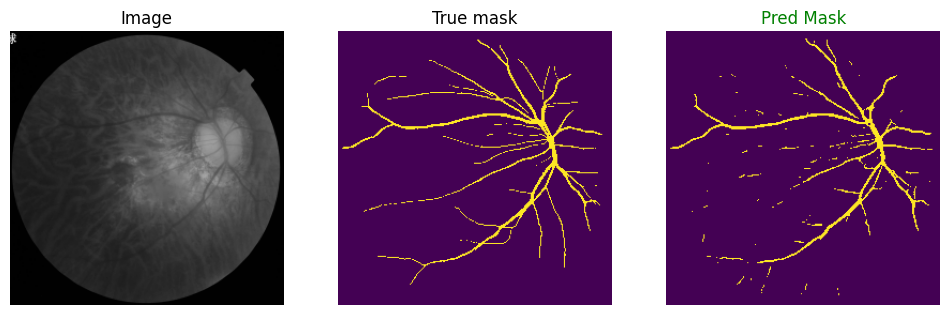

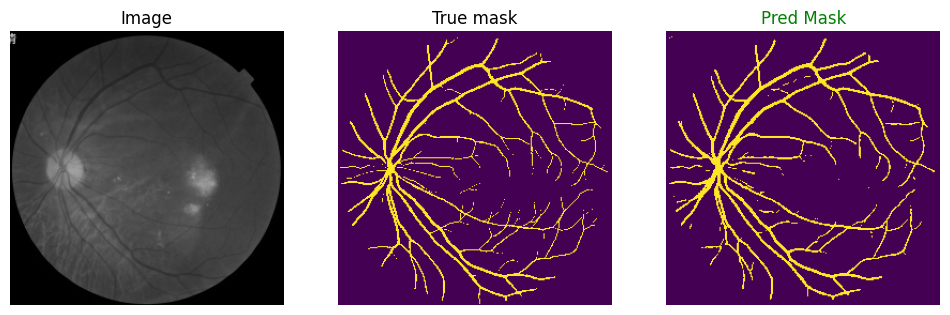

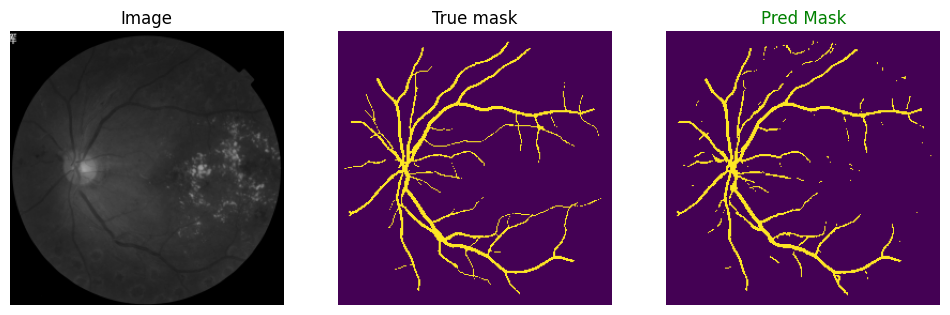

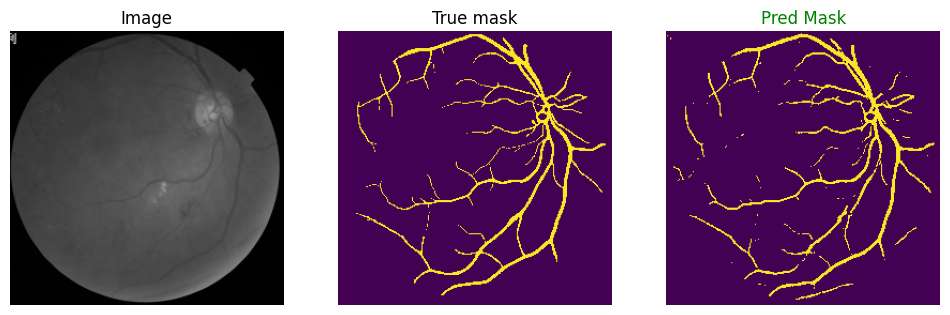

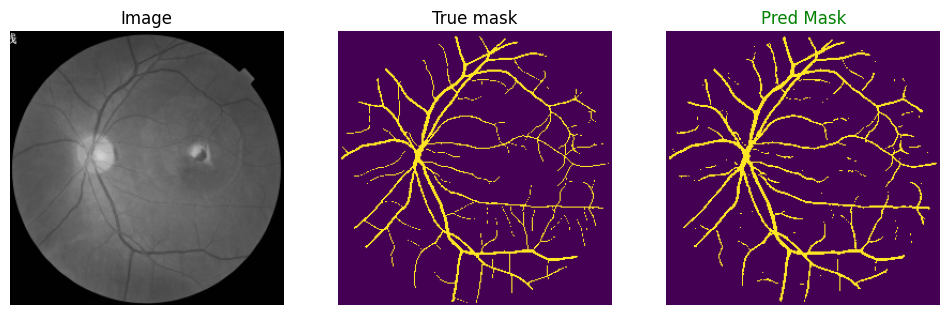

In [29]:
for i in range(5):
    plot(best_model,train_set[np.random.randint(0,len(test_set))],device)

**Show Random 5 test_image**

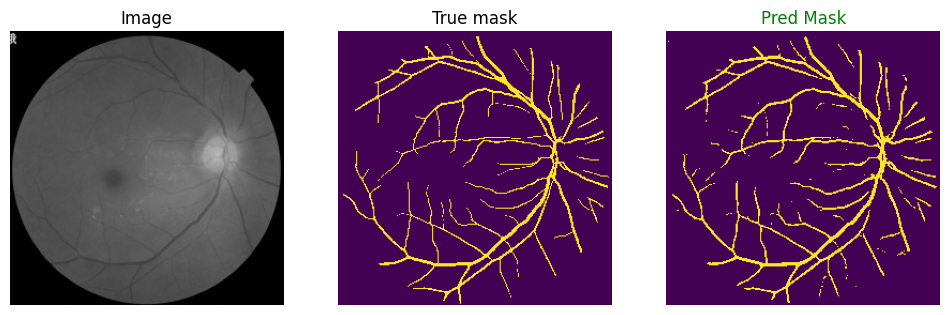

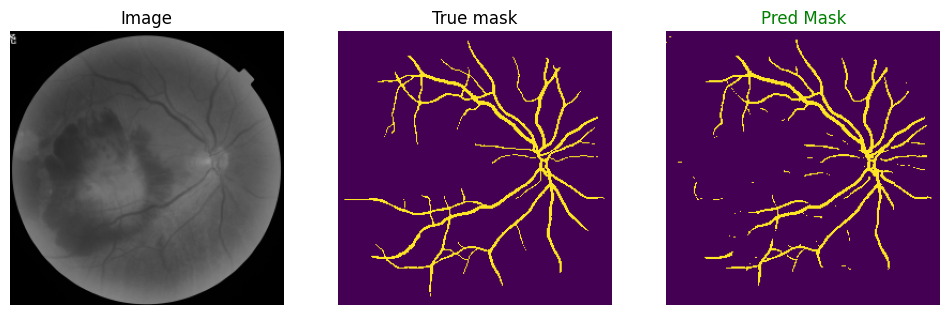

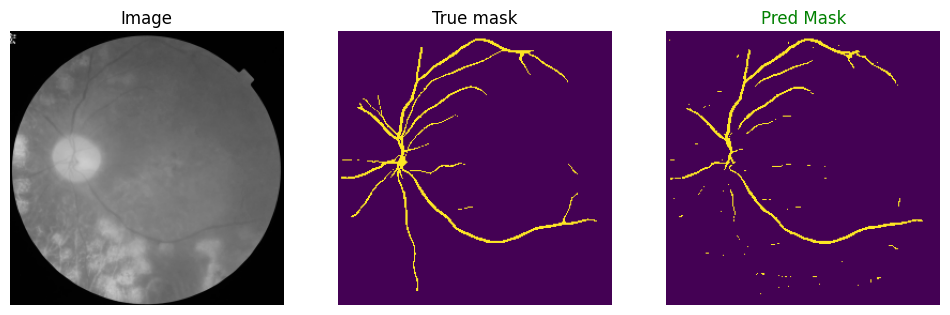

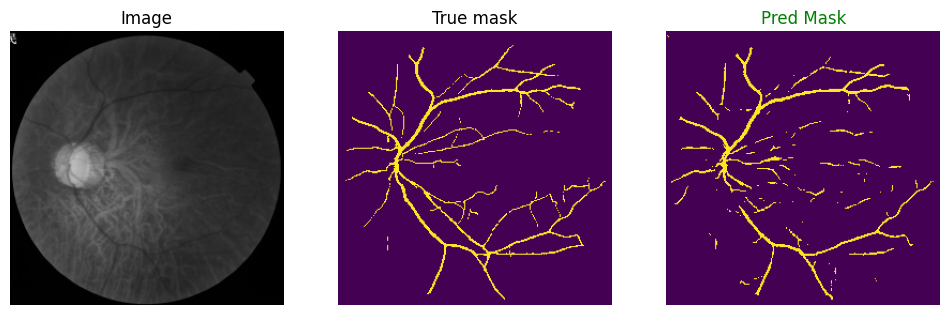

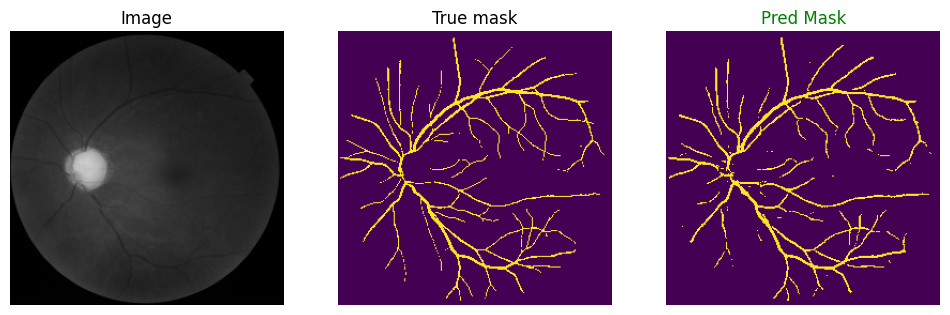

In [30]:
for i in range(5):
    plot(best_model,test_set[np.random.randint(0,len(test_set))],device)

**Score**

In [31]:
eval_for_seg(best_model,test_loader,device)

(tensor(0.8166), 0.8217313885688782, 0.9853244423866272, 0.9035278558731079)

**Show Feature map per encode layers**

In [119]:
def plot_feature_per_conv(sample,model):
    module_dict = {name: module for name, module in model.named_modules()
             if isinstance(module, (nn.Conv2d,nn.ReLU,nn.BatchNorm2d))}
    len_conv_dict = len({name: module for name, module in model.named_modules()
             if isinstance(module, (nn.Conv2d))})
    tmp=sample['image'].unsqueeze(0)
    i=0
    for module in module_dict.values():
        module.to('cpu')
        tmp=module(tmp.cpu())
        if isinstance(module,nn.Conv2d):
            plt.imshow(torch.sigmoid(torch.max(tmp[0],0).values.detach().cpu())*255,cmap='gray')
            plt.axis(False)
            plt.show(())
            i+=1
            plt.title(f'Feature map in conv:{i}')
        if i==len_conv_dict//2:break

**Model chua duoc hoc**

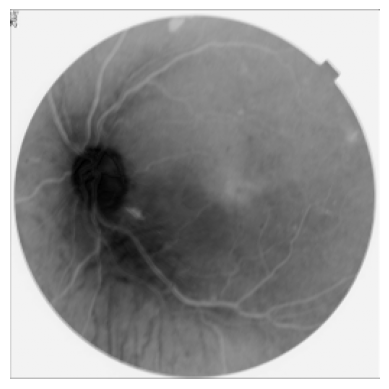

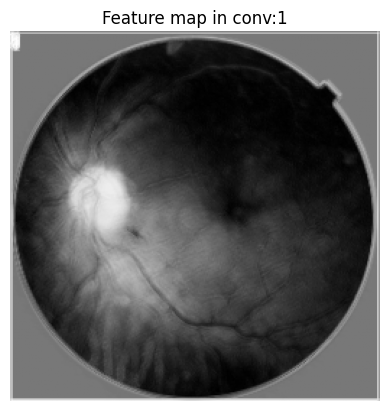

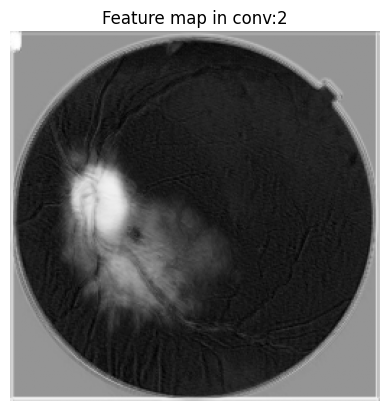

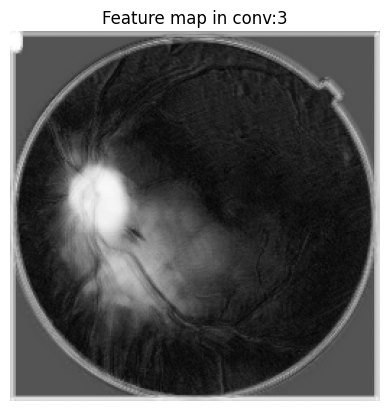

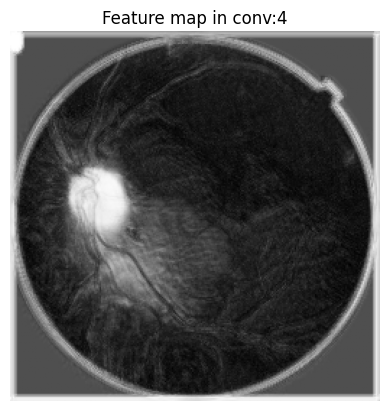

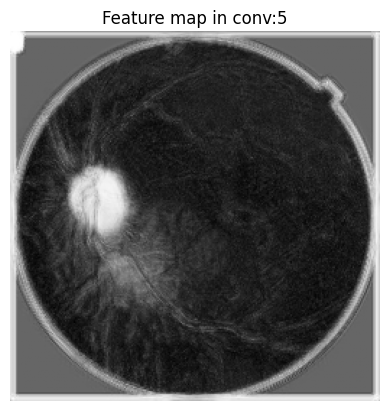

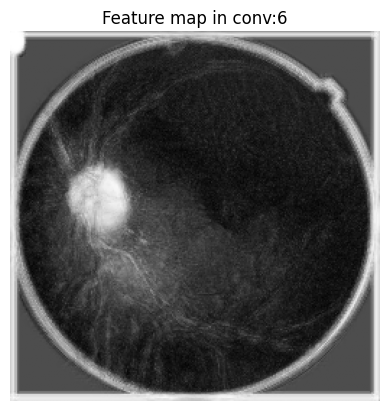

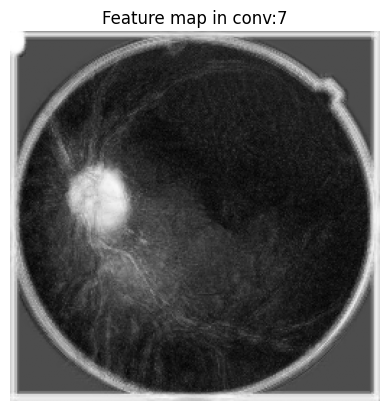

In [121]:
plot_feature_per_conv(test_set[0],nn.Sequential(UNETModel(3,1),nn.Sigmoid()))

**Model da duoc hoc**

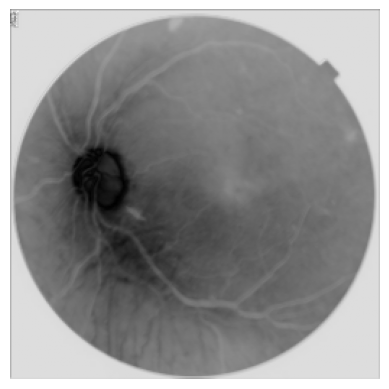

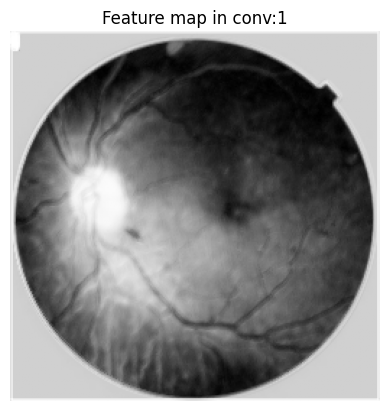

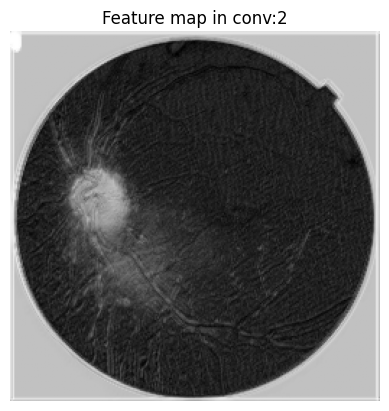

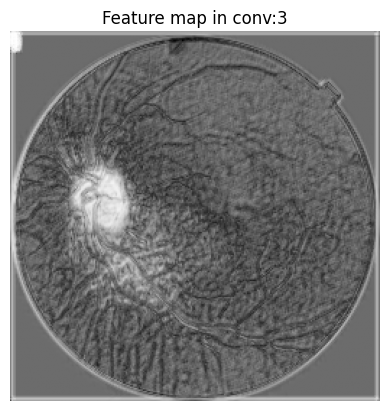

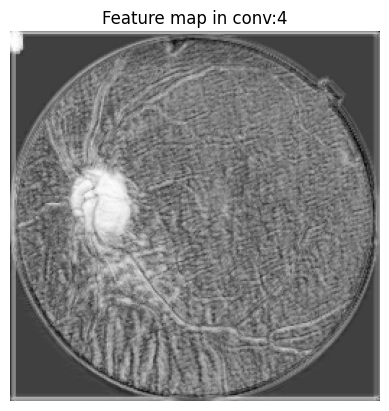

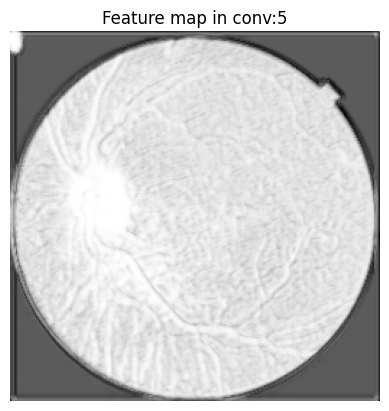

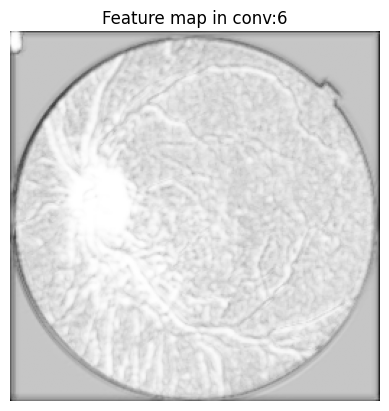

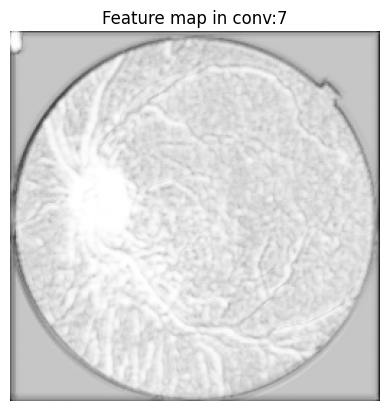

In [120]:
plot_feature_per_conv(test_set[0],best_model)